In [31]:
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision
import torchvision.transforms as transforms

data_root = './celeba_data'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

celeba_train = torchvision.datasets.CelebA(
    root=data_root,
    split='train',
    target_type='attr',
    transform=transform,
    download=True
)


Files already downloaded and verified


 Identify a "Rare” Attribute Combination & Downsample the Rare Group

In [32]:
all_attrs = celeba_train.attr  # shape: [num_samples, 40]

# Get the indices of the attributes we care about
bald_idx = attr_names.index('Bald')
bangs_idx = attr_names.index('Bangs')
smiling_idx = attr_names.index('Smiling')

# Identify the "rare" combo
rare_indices = []
for i in range(len(celeba_train)):
    row = all_attrs[i]
    if row[bald_idx] == 0 and row[bangs_idx] == 0 and row[smiling_idx] == 1:
        rare_indices.append(i)

# Indices for everything else
other_indices = [i for i in range(len(celeba_train)) if i not in rare_indices]

# Downsample the rare group to 10% of its original size
import random
random.shuffle(rare_indices)
keep_ratio = 0.1
keep_count = int(len(rare_indices) * keep_ratio)
rare_indices_downsampled = rare_indices[:keep_count]

# Final imbalanced set
final_indices = other_indices + rare_indices_downsampled
celeba_train_imbalanced = Subset(celeba_train, final_indices)


In [33]:
def count_attributes(dataset, attr_names_list):
    """Count how many images in 'dataset' have each attribute in attr_names_list."""
    
    # We'll assume 'dataset' is CelebA or a Subset of CelebA with 'attr' accessible
    # For a Subset, dataset.dataset.attr is the underlying attribute matrix,
    # and dataset.indices is the list of subset indices.
    
    # Collect attribute counts in a dict
    attr_count_dict = {attr: 0 for attr in attr_names_list}
    
    # The underlying dataset with the 'attr' field
    full_dataset = dataset.dataset if isinstance(dataset, Subset) else dataset
    
    for i in range(len(dataset)):
        # If 'dataset' is a Subset, the real index is dataset.indices[i]
        real_idx = dataset.indices[i] if isinstance(dataset, Subset) else i
        
        # Row of attributes for this image
        row = full_dataset.attr[real_idx]
        
        for attr in attr_names_list:
            idx = attr_names.index(attr)
            if row[idx] == 1:  # or +1 in older versions
                attr_count_dict[attr] += 1
    
    return attr_count_dict


Visualize the Attribute Distribution

In [34]:
attrs_of_interest = ['Bald', 'Bangs', 'Smiling']

original_counts = count_attributes(celeba_train, attrs_of_interest)
imbalanced_counts = count_attributes(celeba_train_imbalanced, attrs_of_interest)

print("Original dataset counts:", original_counts)
print("Downsampled dataset counts:", imbalanced_counts)


Original dataset counts: {'Bald': 3713, 'Bangs': 24685, 'Smiling': 78080}
Downsampled dataset counts: {'Bald': 3713, 'Bangs': 24685, 'Smiling': 21587}


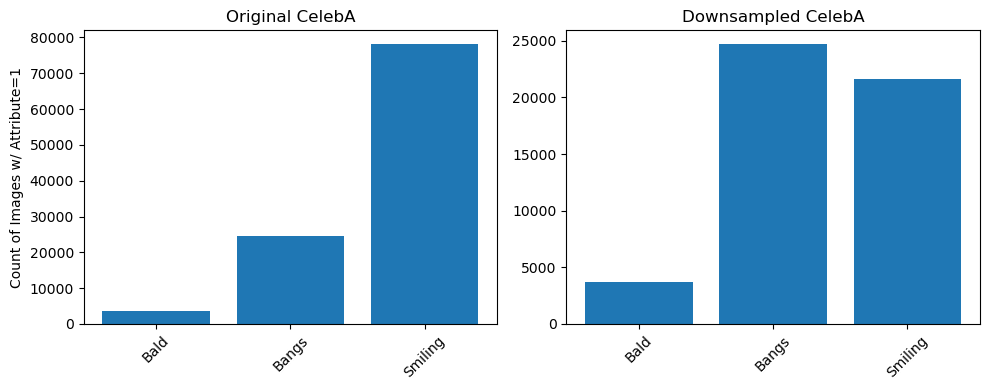

In [37]:
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

x_pos = np.arange(len(attrs_of_interest))

# Subplot 1: Original
orig_values = [original_counts[attr] for attr in attrs_of_interest]
axes[0].bar(x_pos, orig_values)
axes[0].set_title('Original CelebA')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(attrs_of_interest, rotation=45)
axes[0].set_ylabel('Count of Images w/ Attribute=1')

# Subplot 2: Downsampled
imbal_values = [imbalanced_counts[attr] for attr in attrs_of_interest]
axes[1].bar(x_pos, imbal_values)
axes[1].set_title('Downsampled CelebA')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(attrs_of_interest, rotation=45)

plt.tight_layout()
plt.show()


In [38]:
def count_rare_combo(dataset, bald_idx, bangs_idx, smiling_idx):
    full_dataset = dataset.dataset if isinstance(dataset, Subset) else dataset
    count = 0
    for i in range(len(dataset)):
        real_idx = dataset.indices[i] if isinstance(dataset, Subset) else i
        row = full_dataset.attr[real_idx]
        if row[bald_idx] == 0 and row[bangs_idx] == 0 and row[smiling_idx] == 1:
            count += 1
    return count

original_rare_count = count_rare_combo(celeba_train, bald_idx, bangs_idx, smiling_idx)
imbal_rare_count = count_rare_combo(celeba_train_imbalanced, bald_idx, bangs_idx, smiling_idx)

print("Rare combo in original:", original_rare_count)
print("Rare combo in downsampled:", imbal_rare_count)


Rare combo in original: 62769
Rare combo in downsampled: 6276
